In [1]:
#%%capture
import delfi.distribution as dd
import delfi.utils.io as io
import numpy as np
import pickle

import delfi.inference as infer
import delfi.generator as dg
from delfi.simulator import GaussMixture
import delfi.summarystats as ds

%run -i DDELFI.py


def run_panel_a(algo, seed, rounds=5, n_train=[200, 1000]):
    n_params = 1
    m = GaussMixture(dim=n_params, noise_cov=[1.0, 0.01], seed=seed)
    p = dd.Uniform(lower=[-10], upper=[10], seed=seed)
    s = ds.Identity()
    g = dg.Default(model=m, prior=p, summary=s)

    obs = np.array([[0.]])
    kwargs = {'generator': g, 
              'reg_lambda': 0.01,
              'n_components': 2, 
              'n_hiddens': [20], 
              'verbose' : True,
              'obs': obs.copy(),
              'seed': seed}

    
    train = []
    for r in range(rounds):
        train.append(n_train[0])
    train[-1] = n_train[-1]

    
    round_cl=999
    minibatch=100
    n_gradients = 100000
    epochs = [n_gradients // (n_train//minibatch) for n_train in train]
    

    print('n_train :', train)
    print('epochs :', epochs)
    
    if algo == 'CDELFI':
        inf = infer.CDELFI(**kwargs)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,         
                                              n_rounds=len(train),
                                              epochs=epochs)
    elif algo == 'SNPE':
        inf = infer.SNPE(**kwargs,convert_to_T=3)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,                                              
                                              n_rounds=len(train),
                                              epochs=epochs, 
                                              round_cl=round_cl)        
    elif algo == 'kSNPE':
        inf = infer.SNPE(**kwargs,convert_to_T=3)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,                                              
                                              n_rounds=len(train),
                                              epochs=epochs, 
                                              kernel_loss='x_kl', 
                                              round_cl=round_cl)              
    elif algo == 'DDELFI':
        inf = DDELFI(**kwargs, convert_to_T=None)
        log, train_data, posteriors, _ = inf.run(n_train=train,
                                                 minibatch=minibatch,                                              
                                                 n_rounds=len(train),
                                                 epochs=epochs)              
    
    else:
        raise ValueError
        
    try:
        posterior = inf.predict(obs)
    except:
        posterior = None
    
    return {'algo': algo,
            'rounds': rounds,
            'seed': seed,
            'posterior': posterior,
            'log': log,
            'train_data': train_data,
            'posteriors': posteriors
           }


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:11.9970592384/400
ESS:12.8823308936/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:210.510212618/400
ESS:233.1137508/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.99679708]: : 16it [00:00, 112.01it/s]

loss=[ 2.97720385]: : 1320it [00:09, 141.57it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.99321485]: : 14it [00:00, 119.76it/s]

loss=[ 2.96622467]: : 1222it [00:09, 126.49it/s]


kernel cov:  [[ 0.05195518]]


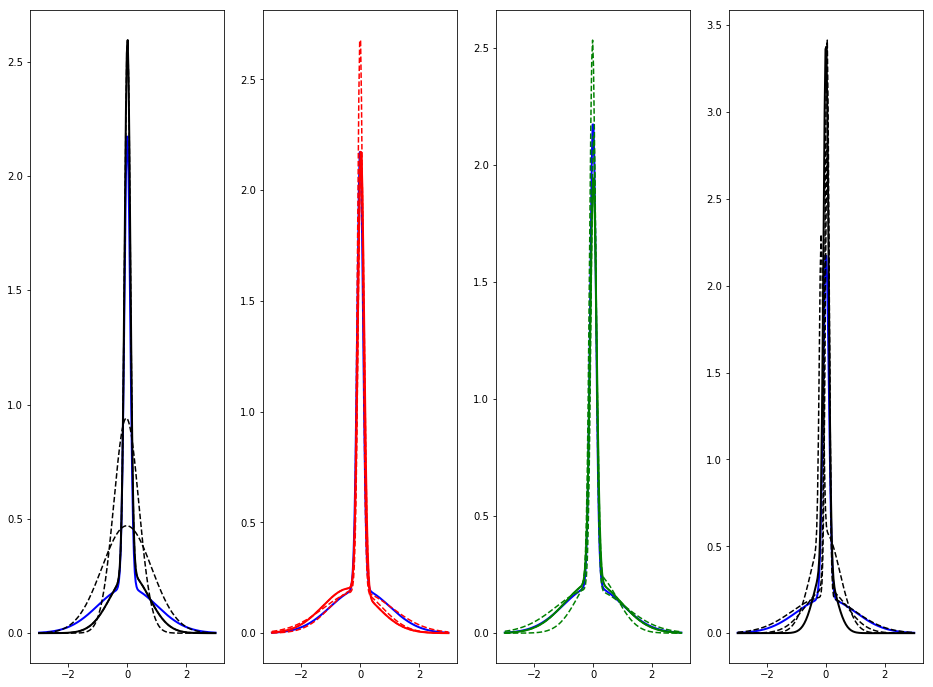

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:18.592763099/400
ESS:24.5431025135/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:132.317905483/400
ESS:387.499547938/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.04573989]: : 17it [00:00, 110.03it/s]

loss=[ 3.01166773]: : 1184it [00:08, 134.36it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.99884415]: : 10it [00:00, 81.02it/s]

loss=[ 2.94430828]: : 1197it [00:08, 136.80it/s]


kernel cov:  [[ 0.10371335]]


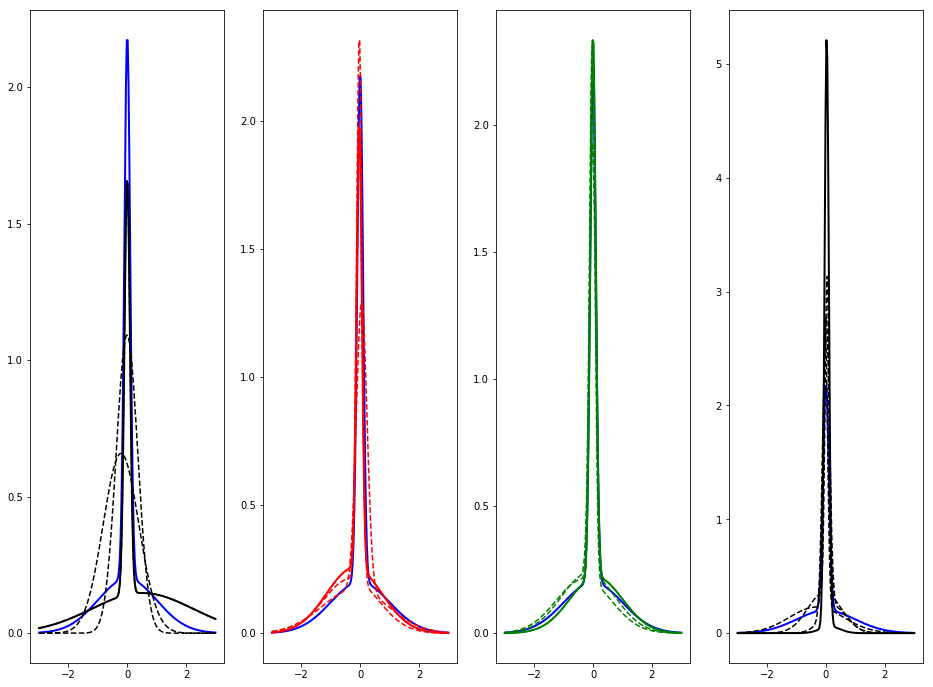

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:24.4715017391/400
ESS:14.6857784296/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:185.491295239/400
ESS:320.450040839/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.1056397]: : 14it [00:00, 119.36it/s] 

loss=[ 3.00169754]: : 3243it [00:23, 136.43it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.05906415]: : 13it [00:00, 102.27it/s]

loss=[ 3.04317856]: : 1961it [00:13, 143.51it/s]


kernel cov:  [[ 0.11180362]]


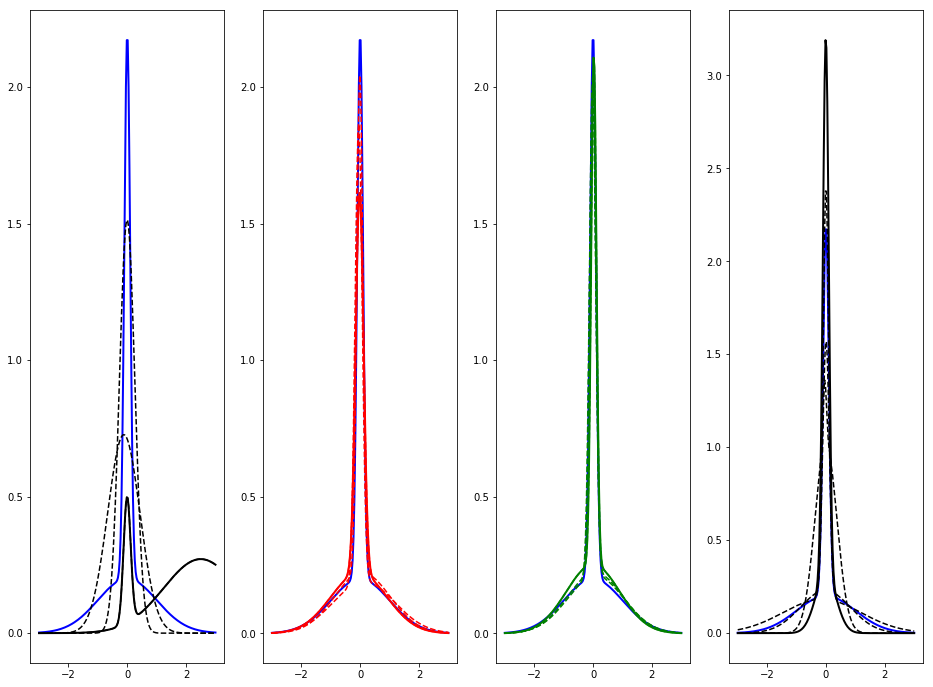

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:6.72090429176/400
ESS:10.0593651417/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:168.105753536/400
ESS:546.797573608/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.1307404]: : 14it [00:00, 123.53it/s] 

loss=[ 3.00199485]: : 3006it [00:22, 132.91it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.04235029]: : 9it [00:00, 53.65it/s]

loss=[ 3.03331447]: : 1196it [00:14, 79.95it/s]


kernel cov:  [[ 0.07375083]]


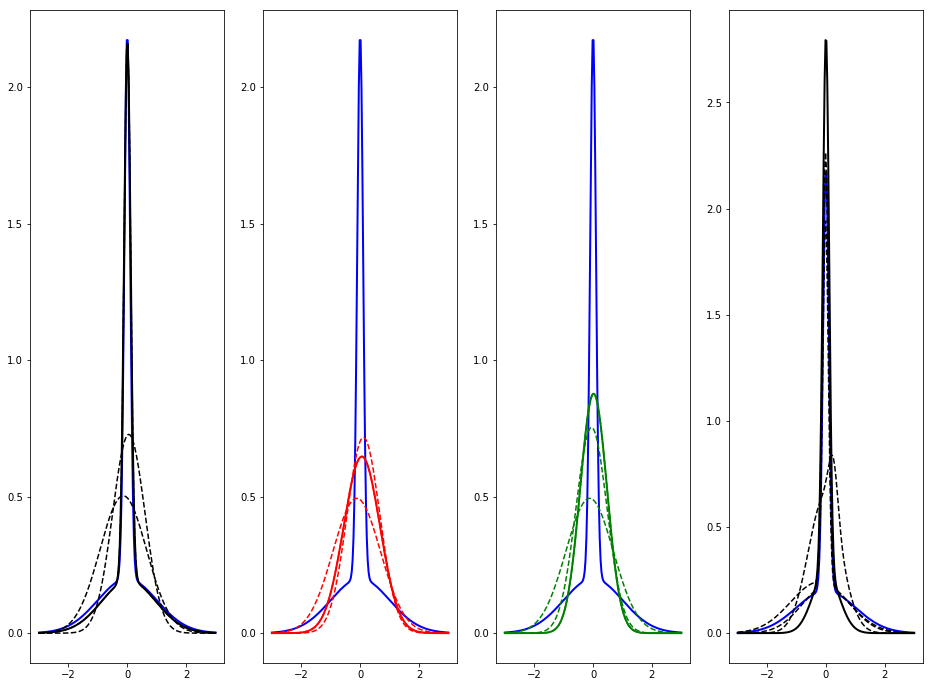

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:7.90281454357/400
ESS:11.3300215665/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:132.213440876/400
ESS:441.718900647/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.99163103]: : 15it [00:00, 96.39it/s] 

loss=[ 2.89413929]: : 1665it [00:11, 150.08it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.99454331]: : 16it [00:00, 102.60it/s]

loss=[ 2.97788906]: : 1118it [00:07, 143.41it/s]


kernel cov:  [[ 0.14589094]]


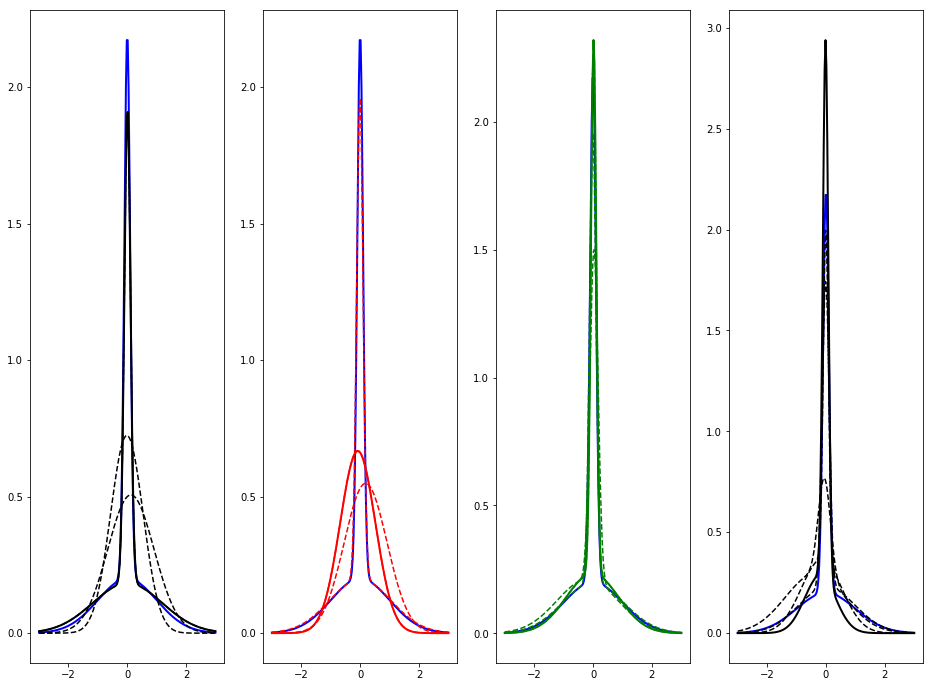

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:7.67628474679/400
ESS:19.9525646713/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:154.563390049/400
ESS:331.037213373/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.03595686]: : 17it [00:00, 115.64it/s]

loss=[ 2.9513998]: : 1705it [00:11, 153.91it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.0160861]: : 7it [00:00, 54.55it/s] 

loss=[ 2.97447252]: : 1380it [00:21, 63.34it/s]


kernel cov:  [[ 0.07724984]]


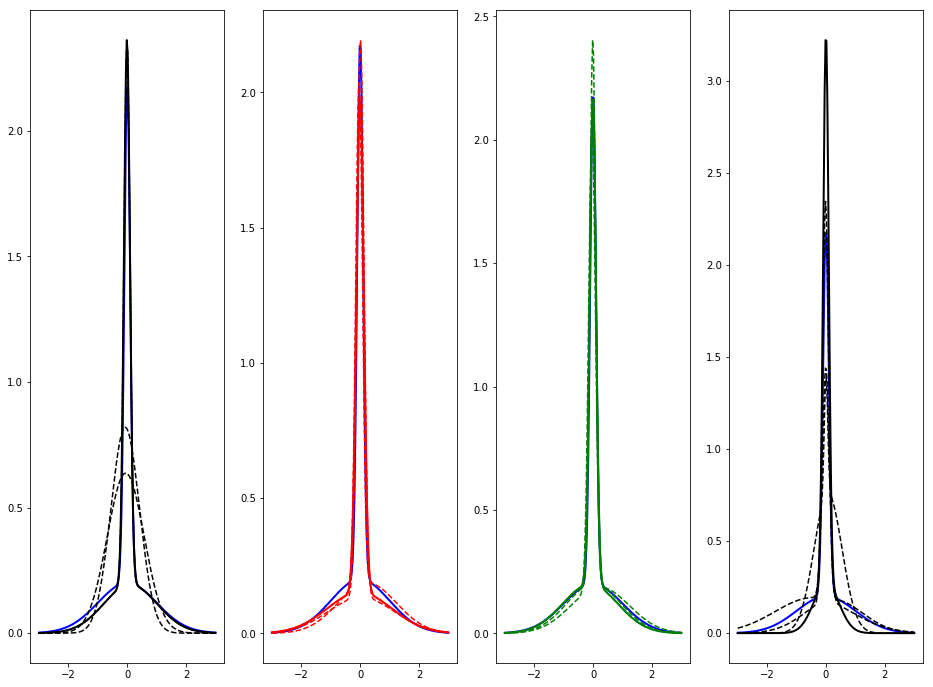

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:15.812302512/400
ESS:21.0637249117/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:177.61935536/400
ESS:455.155210069/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.11965942]: : 6it [00:00, 47.92it/s]

loss=[ 2.96755791]: : 1818it [00:27, 66.57it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.05431128]: : 16it [00:00, 124.87it/s]

loss=[ 3.02684021]: : 1147it [00:08, 134.03it/s]


kernel cov:  [[ 0.10967395]]


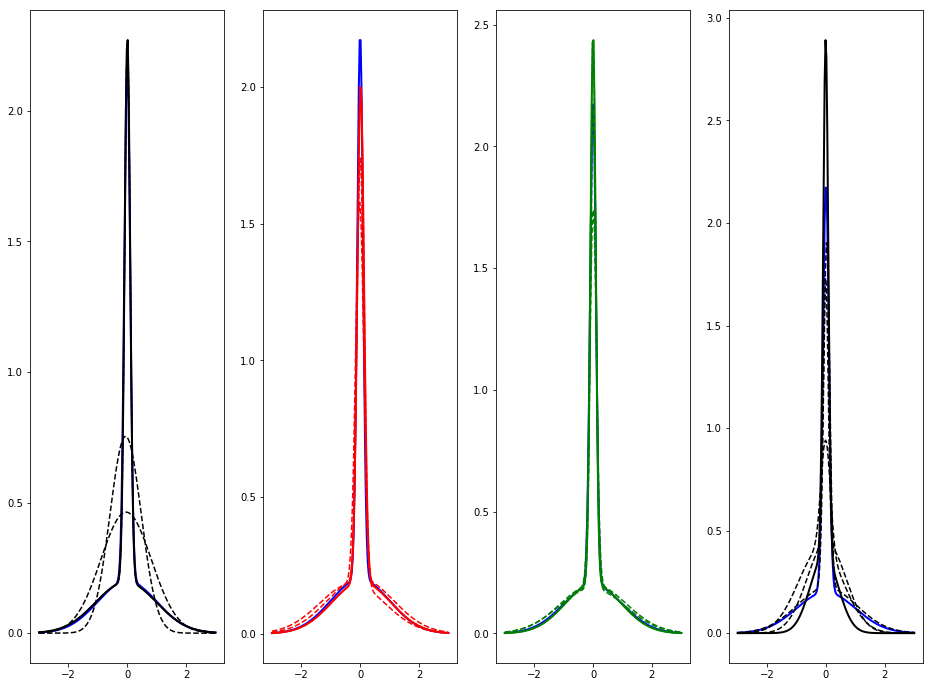

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:6.74071499721/400
ESS:26.2884512038/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:178.530673363/400
ESS:304.721015236/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.06665707]: : 16it [00:00, 100.88it/s]

loss=[ 2.96639395]: : 3041it [00:21, 143.41it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.07903147]: : 16it [00:00, 101.66it/s]

loss=[ 3.06605959]: : 1494it [00:10, 141.11it/s]


kernel cov:  [[ 0.07409571]]


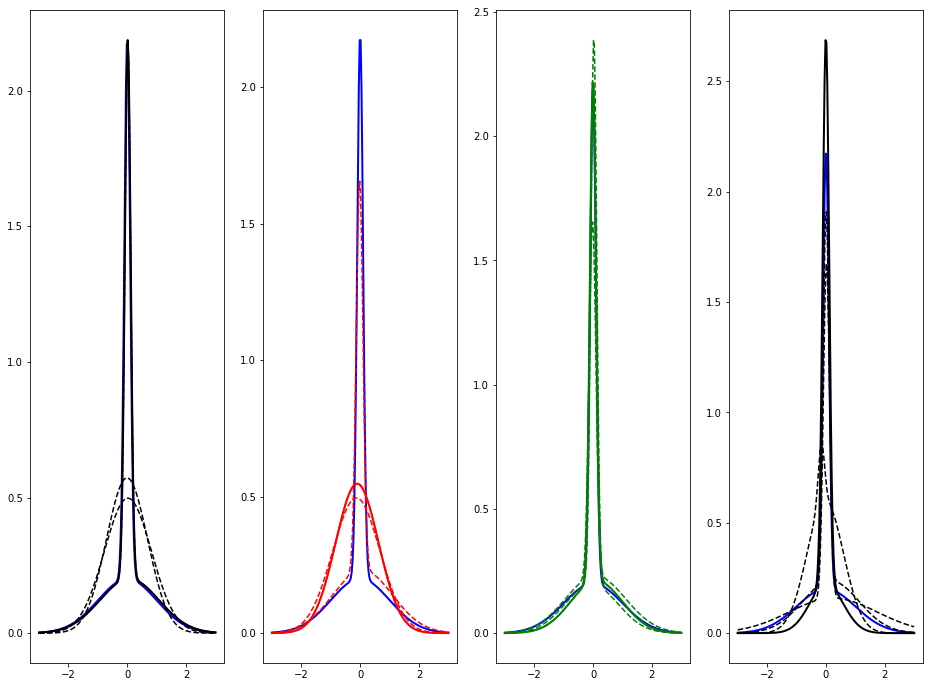

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:13.9144484494/400
ESS:20.143636171/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:137.679803528/400
ESS:354.628463933/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.93578291]: : 16it [00:00, 111.46it/s]

loss=[ 2.89682531]: : 1420it [00:09, 145.55it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.92492557]: : 17it [00:00, 107.34it/s]

loss=[ 2.92437863]: : 1074it [00:07, 152.23it/s]


kernel cov:  [[ 0.09062976]]


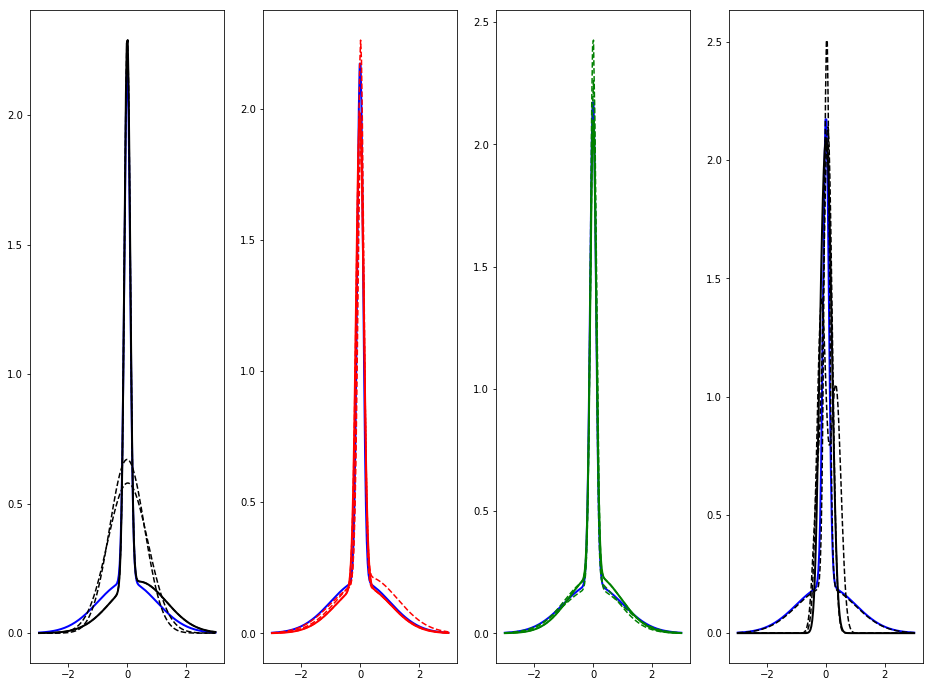

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:19.5380601759/400
ESS:6.14019350048/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:194.046783905/400
ESS:307.116747424/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.01542234]: : 16it [00:00, 111.50it/s]

loss=[ 2.97377729]: : 1209it [00:08, 140.89it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.0618279]: : 16it [00:00, 103.08it/s] 

loss=[ 3.01664495]: : 1277it [00:08, 144.61it/s]


kernel cov:  [[ 0.06941495]]


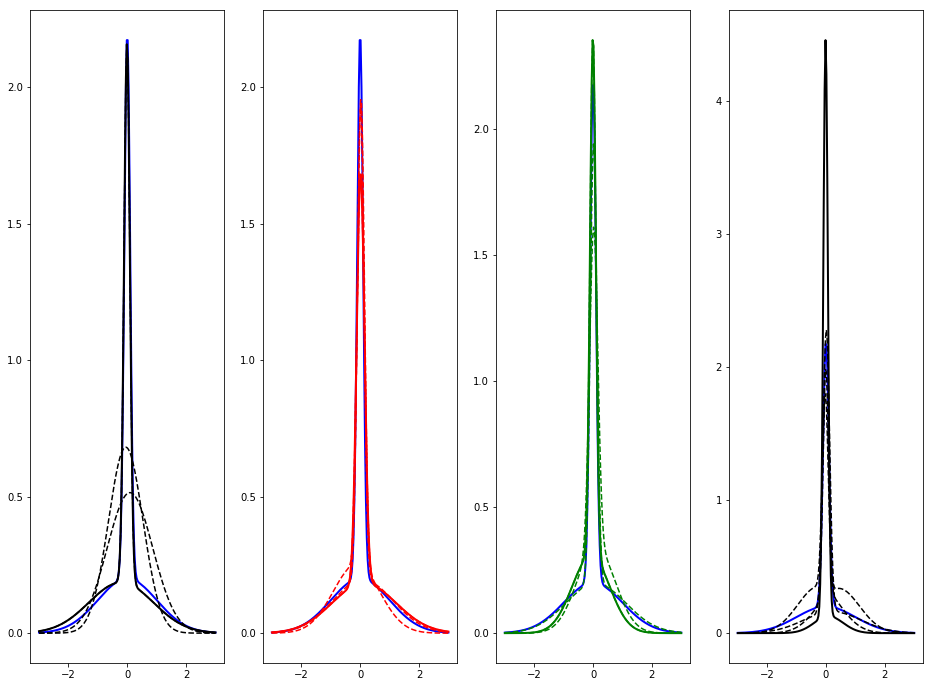

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:27.5203819511/400
ESS:34.3758786182/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:154.548380355/400
ESS:386.705241429/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.20676112]: : 6it [00:00, 50.90it/s]

loss=[ 3.0292201]: : 2225it [00:25, 86.25it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.98556399]: : 15it [00:00, 112.48it/s]

loss=[ 2.98110771]: : 1102it [00:16, 67.61it/s]


kernel cov:  [[ 0.1033093]]


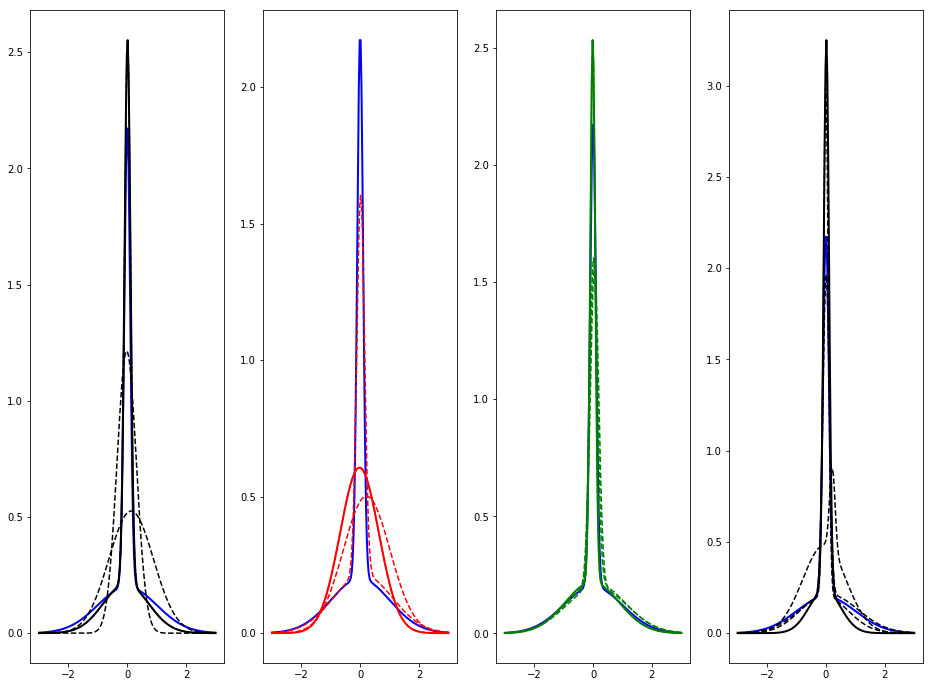

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:19.7592227983/400
ESS:62.9824104189/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:90.8567923641/400
ESS:208.854527313/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.010396]: : 0it [00:00, ?it/s]  

loss=[ 2.97304296]: : 1124it [00:46, 24.17it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.97930288]: : 0it [00:00, ?it/s]

loss=[ 2.91209745]: : 1467it [00:20, 73.30it/s]


kernel cov:  [[ 0.08648923]]


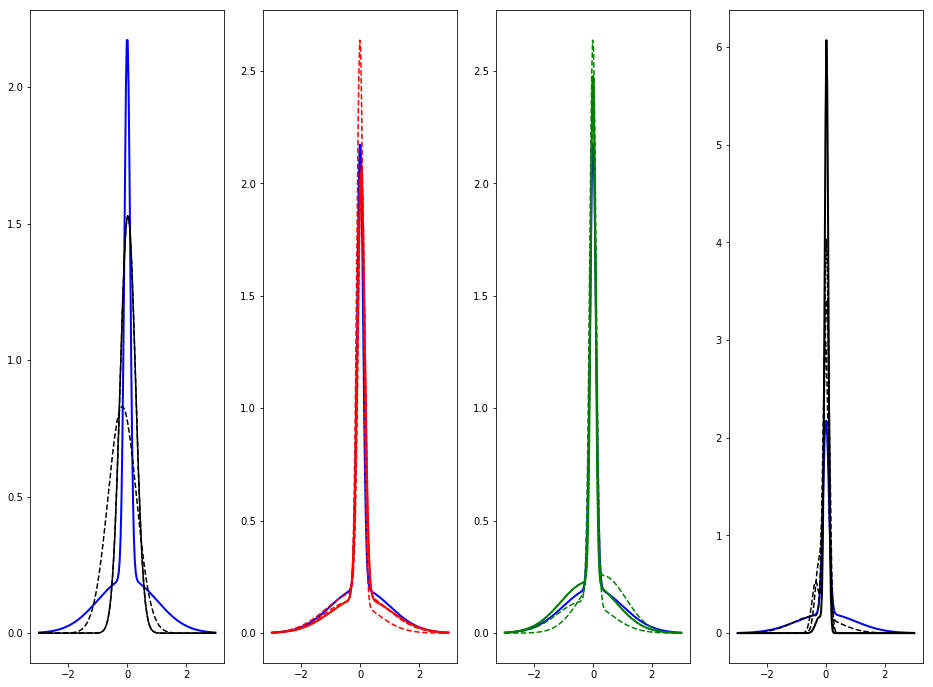

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:16.9620107048/400
ESS:26.1860358079/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:173.798678269/400
ESS:265.7666231/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.11365247]: : 0it [00:00, ?it/s]

loss=[ 2.98966384]: : 1833it [01:00, 30.31it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.05689764]: : 0it [00:00, ?it/s]

loss=[ 3.00824523]: : 1354it [00:47, 28.26it/s]


kernel cov:  [[ 0.12007015]]


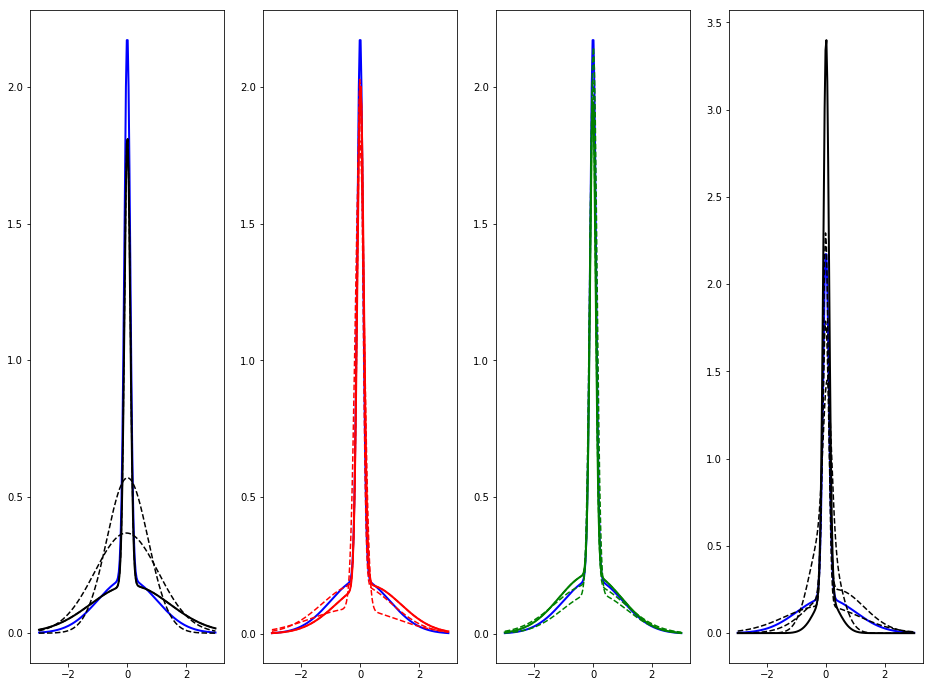

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:19.3893973516/400
ESS:28.6192201274/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:174.977968754/400
ESS:442.959826355/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.07759356]: : 0it [00:00, ?it/s]

loss=[ 2.90079498]: : 3705it [01:16, 48.12it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.07601142]: : 0it [00:00, ?it/s]

loss=[ 3.05599141]: : 1738it [01:01, 28.42it/s]


kernel cov:  [[ 0.1106611]]


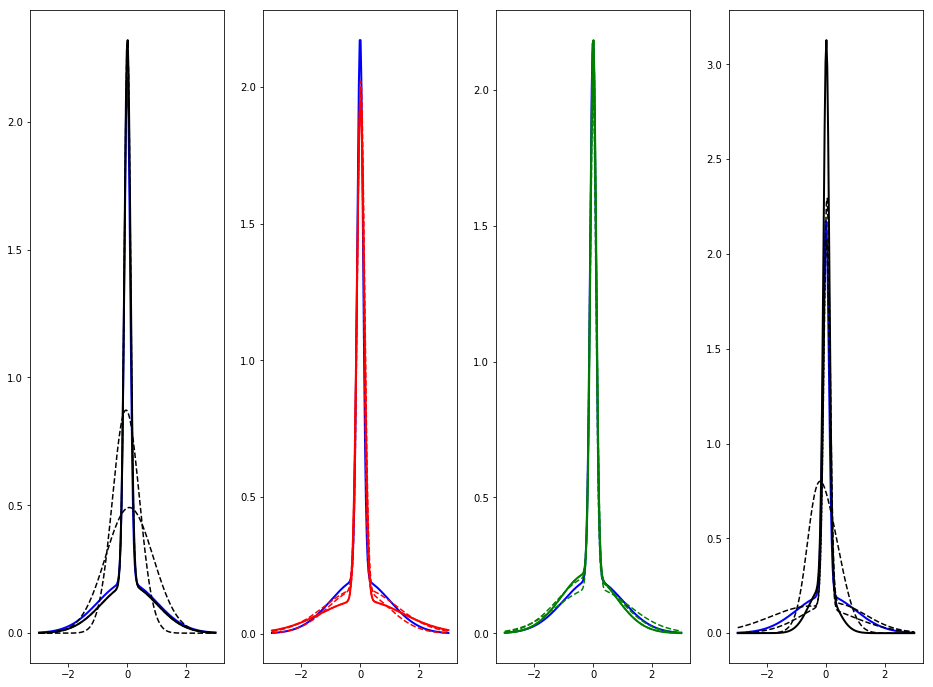

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:16.026499179/400
ESS:11.1792375615/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:128.230939594/400
ESS:263.476223797/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.18719912]: : 0it [00:00, ?it/s]

loss=[ 2.99914098]: : 2284it [01:11, 32.06it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.04824305]: : 5it [00:00, 46.81it/s]

loss=[ 3.00969291]: : 1119it [00:38, 29.20it/s]


kernel cov:  [[ 0.06416911]]


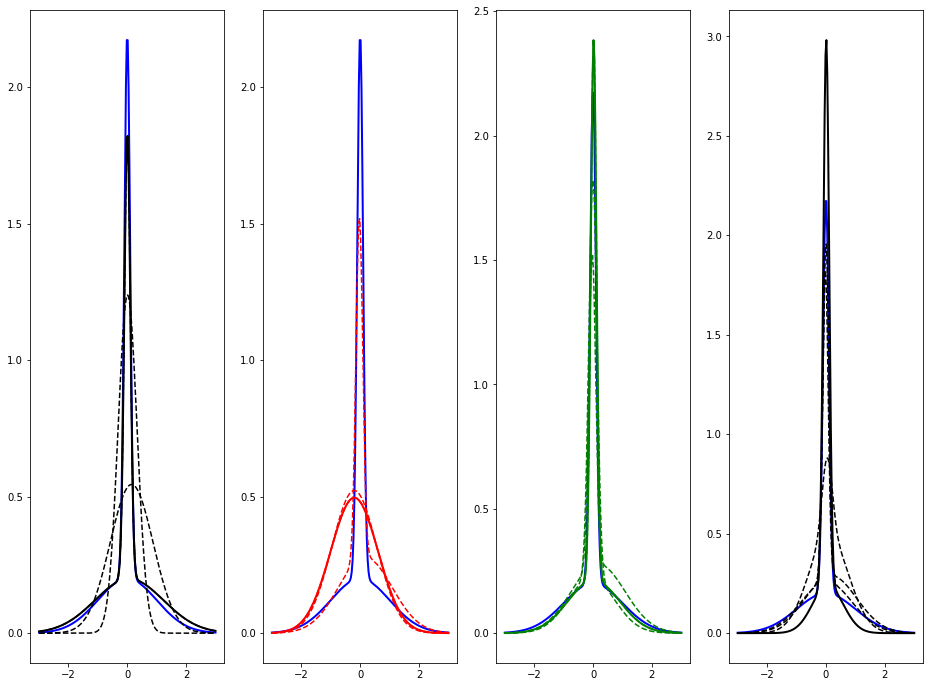

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:38.8460253346/400
ESS:13.3184756204/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:134.044129475/400
ESS:351.354294982/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.18190932]: : 0it [00:00, ?it/s]

loss=[ 3.02193522]: : 2081it [01:13, 28.17it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.07711411]: : 0it [00:00, ?it/s]

loss=[ 3.04644799]: : 1208it [00:38, 31.41it/s]


kernel cov:  [[ 0.1146384]]


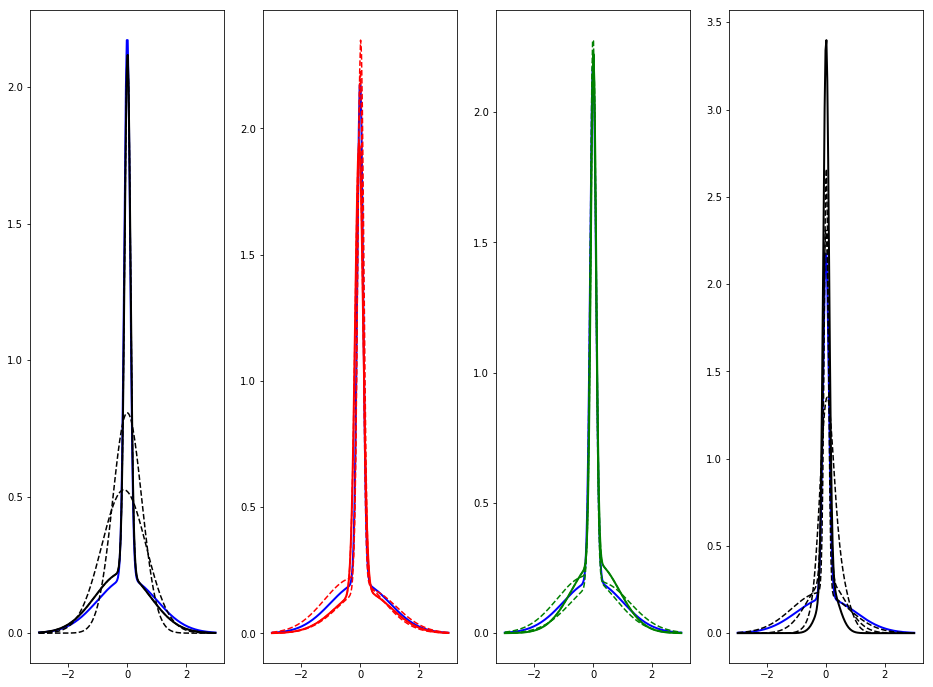

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:9.76745616175/400
ESS:30.2489828049/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:187.331080033/400
ESS:411.443919297/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.10756588]: : 0it [00:00, ?it/s]

loss=[ 2.96532917]: : 1306it [00:44, 29.28it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.07929778]: : 0it [00:00, ?it/s]

loss=[ 3.06535912]: : 3445it [02:17, 25.01it/s]


kernel cov:  [[ 0.07999826]]


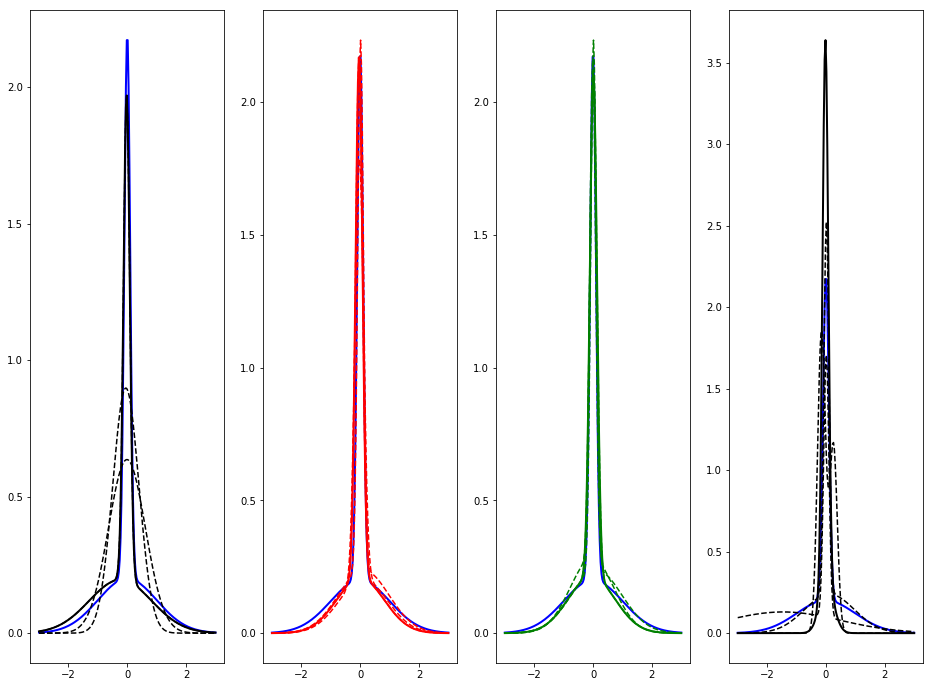

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:4.50139781311/400
ESS:16.5798392894/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:139.11254442/400
ESS:324.970690307/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.17035484]: : 0it [00:00, ?it/s]

loss=[ 3.01506591]: : 6618it [02:56, 37.60it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 5.13198328]: : 0it [00:00, ?it/s]

loss=[ 5.03446198]: : 1146it [00:49, 23.38it/s]


kernel cov:  [[ 0.11704284]]


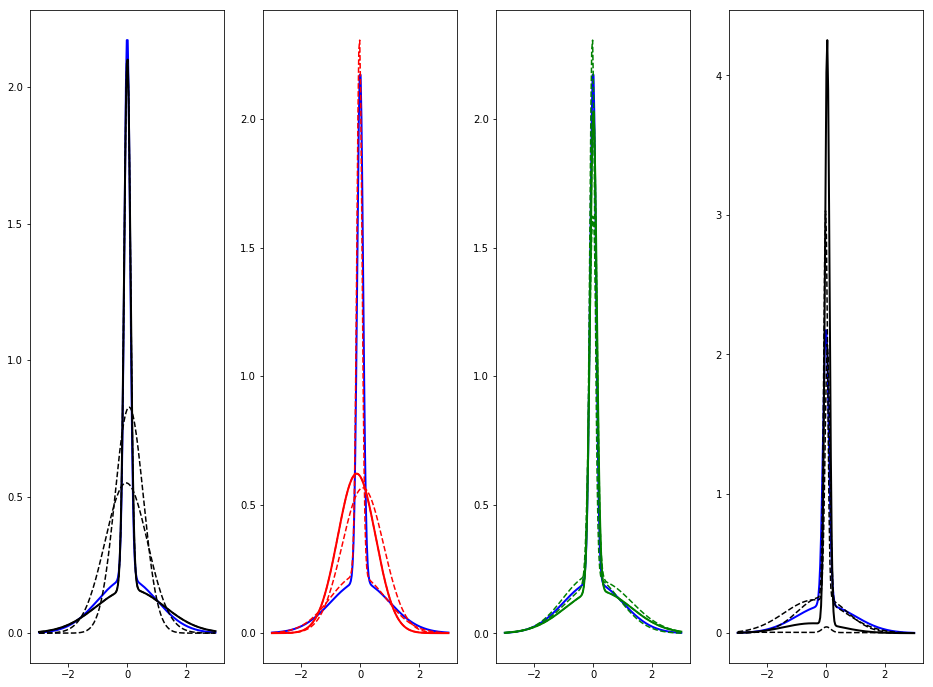

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:9.74186570677/400
ESS:30.9430160775/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:149.557531106/400
ESS:202.940608375/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.23021865]: : 0it [00:00, ?it/s]

loss=[ 2.99857521]: : 1558it [00:40, 38.77it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.13026595]: : 0it [00:00, ?it/s]

loss=[ 3.05849409]: : 1131it [00:49, 22.76it/s]


kernel cov:  [[ 0.05073533]]


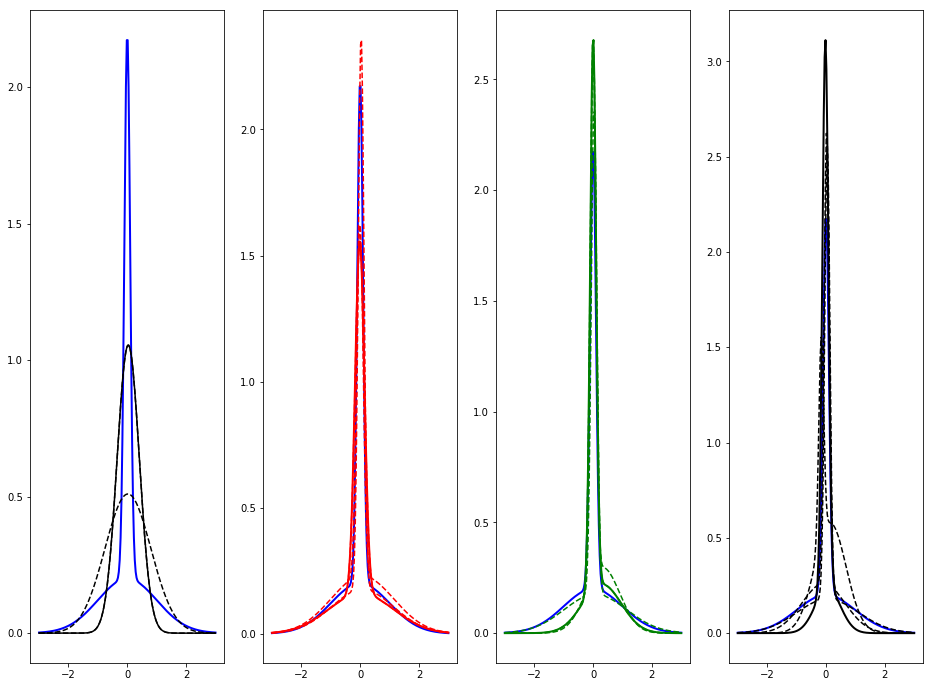

n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


ESS:400.0/400
ESS:7.74949702112/400
ESS:56.0004242627/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


ESS:400.0/400
ESS:167.948437658/400
ESS:296.927812024/1000
n_train : [400, 400, 1000]
epochs : [25000, 25000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.14313555]: : 2it [00:00, 19.54it/s]

loss=[ 2.97981882]: : 1671it [01:04, 26.07it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.00300884]: : 3it [00:00, 29.73it/s]

loss=[ 2.95953155]: : 1123it [00:44, 25.25it/s]


kernel cov:  [[ 0.08524823]]


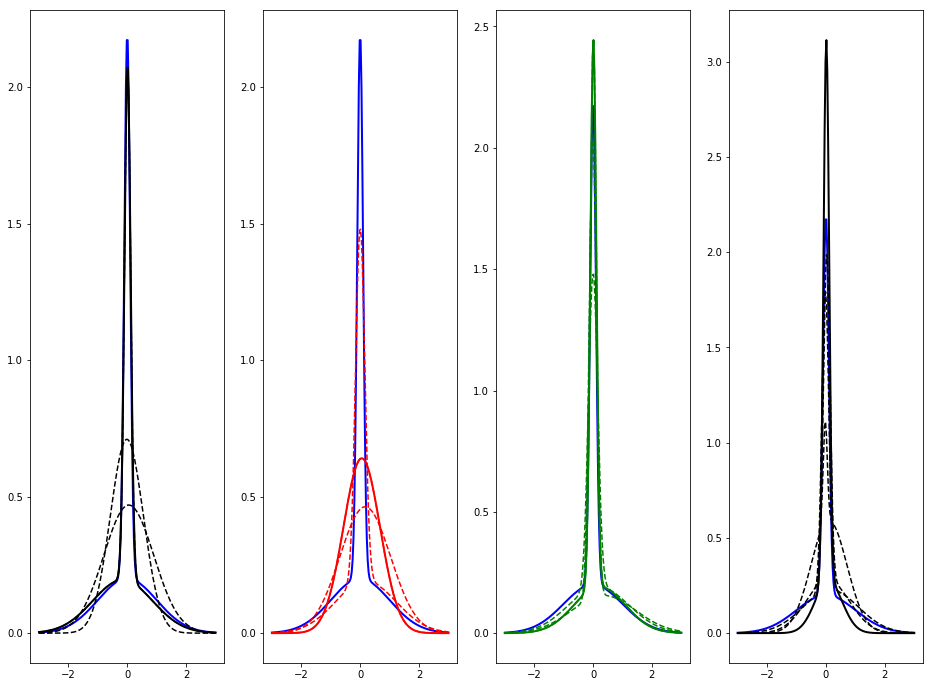

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

seeds = range(90, 110)
n_train = [400, 400, 1000]
rounds = len(n_train)

all_outs_SNPE, all_outs_kSNPE, all_outs_CDELFI, all_outs_DDELFI = [], [], [], []
p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([0.]), np.asarray([0.])], Ss=[1.0*np.eye(1), 0.01*np.eye(1)])

for seed in seeds:
    
    plt.figure(figsize=(16,12))

    out = run_panel_a(algo='CDELFI', rounds=rounds, seed=seed, n_train=n_train)
    
    out_SNPE = run_panel_a(algo='SNPE', rounds=rounds, seed=seed, n_train=n_train)
    for r in range(rounds):
        w = out_SNPE['train_data'][r][2]
        w /= w.sum()
        print('ESS:' + str(1/np.sum(w**2)) + '/' + str(w.size))

    out_kSNPE = run_panel_a(algo='kSNPE', rounds=rounds, seed=seed, n_train=n_train)
    for r in range(rounds):
        w = out_kSNPE['train_data'][r][2]
        w /= w.sum()
        print('ESS:' + str(1/np.sum(w**2)) + '/' + str(w.size))

    out_DDELFI = run_panel_a(algo='DDELFI', rounds=rounds, seed=seed, n_train=n_train)
    
    xx = np.linspace(-3, 3, 200).reshape(-1,1)
    
    plt.subplot(1,4,1)
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    try:
        plt.plot(xx,      out['posterior'].eval(xx, log=False), 'k', linewidth=2)
    except:
        tmp = out['posteriors'][-2] if out['posteriors'][-1] is None else out['posteriors'][-1]
        plt.plot(xx,      tmp.eval(xx, log=False), 'k')
    for r in range(rounds):
        try:
            plt.plot(xx, out['posteriors'][r].eval(xx, log=False), 'k--')
        except:
            pass
        
    plt.subplot(1,4,2)
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    plt.plot(xx, out_SNPE['posterior'].eval(xx, log=False), 'r', linewidth=2)
    for r in range(rounds):
        plt.plot(xx, out_SNPE['posteriors'][r].eval(xx, log=False), 'r--')
    
    plt.subplot(1,4,3)    
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    plt.plot(xx,out_kSNPE['posterior'].eval(xx, log=False), 'g', linewidth=2)
    for r in range(rounds):
        plt.plot(xx,out_kSNPE['posteriors'][r].eval(xx, log=False), 'g--')
    
    plt.subplot(1,4,4)
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    try:
        plt.plot(xx, out_DDELFI['posterior'].eval(xx, log=False), 'k', linewidth=2)
    except:
        tmp = out_DDELFI['posteriors'][-2] if out_DDELFI['posteriors'][-1] is None else out_DDELFI['posteriors'][-1]
        plt.plot(xx,      tmp.eval(xx, log=False), 'k')
    for r in range(rounds):
        try:
            plt.plot(xx, out_DDELFI['posteriors'][r].eval(xx, log=False), 'k--')
        except:
            pass        
        
    print('kernel cov: ', 1./out_kSNPE['log'][-1]['cbkrnl'].A )
    all_outs_SNPE.append(out_SNPE)
    all_outs_kSNPE.append(out_kSNPE)
    all_outs_CDELFI.append(out)
    all_outs_DDELFI.append(out_DDELFI)
    
    plt.show()

In [3]:

np.save('MoG_1D_bimodal_20seeds_3round_N1800_results', 
        {'seeds' : seeds, 
         'n_train' : n_train,
         'rounds' : rounds, 
         
         'p_true' : p_true,
         
         'res_CDELFI' : all_outs_CDELFI,
         'res_kSNPE' : all_outs_kSNPE,
         'res_SNPE' : all_outs_SNPE,
         'res_DDELFI' : all_outs_DDELFI,
    })

/Users/kaan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


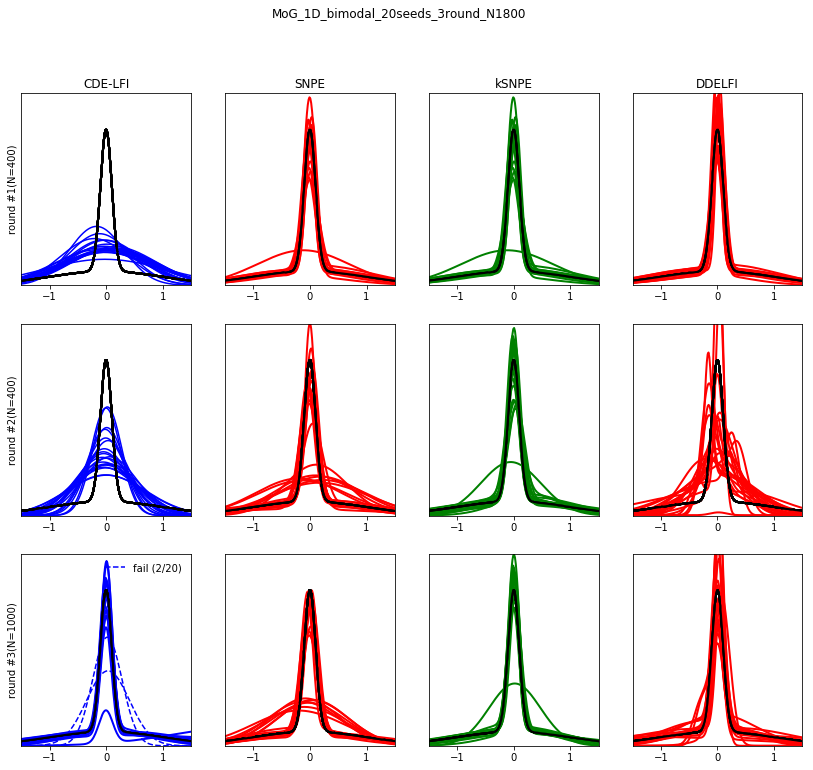

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(14,rounds*4))

fail_count_CDELFI = 0
for i in range(len(seeds)):
    
    seed = seeds[i]

    out = all_outs_CDELFI[i]
    out_SNPE = all_outs_SNPE[i]
    out_kSNPE = all_outs_kSNPE[i]
    out_DDELFI = all_outs_DDELFI[i]
    
    xx = np.linspace(-1.5, 1.5, 200).reshape(-1,1)

    broke_flag = False
    for r in range(rounds):
        if rounds > len(n_train) and r < rounds-1:
            r_ = 0
        elif rounds > len(n_train) and r == rounds-1:
            r_ = len(n_train)-1
        else: 
            r_ = r
        plt.subplot(rounds,4,1 + r*4)
        plt.plot(-20, -20, 'b--', linewidth=1.5)
        if r == rounds-1:
            try:
                plt.plot(xx,      out['posterior'].eval(xx, log=False), 'b', linewidth=2)
            except:
                tmp = out['posteriors'][-2] if out['posteriors'][-1] is None else out['posteriors'][-1]
                plt.plot(xx,      tmp.eval(xx, log=False), 'b--')
                broke_flag=True
                fail_count_CDELFI += 1
        else:
            plt.plot(xx, out['posteriors'][r].eval(xx, log=False), 'b')
        if r == 0:
            plt.title('CDE-LFI')
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        plt.ylabel('round #' + str(r+1) + '(N=' + str(n_train[r_]) + ')')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        if broke_flag:
            plt.legend(['fail (' + str( fail_count_CDELFI ) + '/' +  str(len(seeds))  + ')'], loc=1, frameon=False)

        plt.subplot(rounds,4,2 + r*4)
        plt.plot(xx, out_SNPE['posteriors'][r].eval(xx, log=False), 'r', linewidth=2)
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        if r == 0:
            plt.title('SNPE')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

        
        plt.subplot(rounds,4,3 + r*4)    
        plt.plot(xx,out_kSNPE['posteriors'][r].eval(xx, log=False), 'g', linewidth=2)
        if r == 0:
            plt.title('kSNPE')
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        
        
        plt.subplot(rounds,4,4 + r*4)
        plt.plot(xx, out_DDELFI['posteriors'][r].eval(xx, log=False), 'r', linewidth=2)
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        if r == 0:
            plt.title('DDELFI')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

    plt.suptitle('MoG_1D_bimodal_20seeds_3round_N1800')
    plt.savefig('MoG_1D_bimodal_20seeds_3round_N1800.pdf')
    
plt.show()

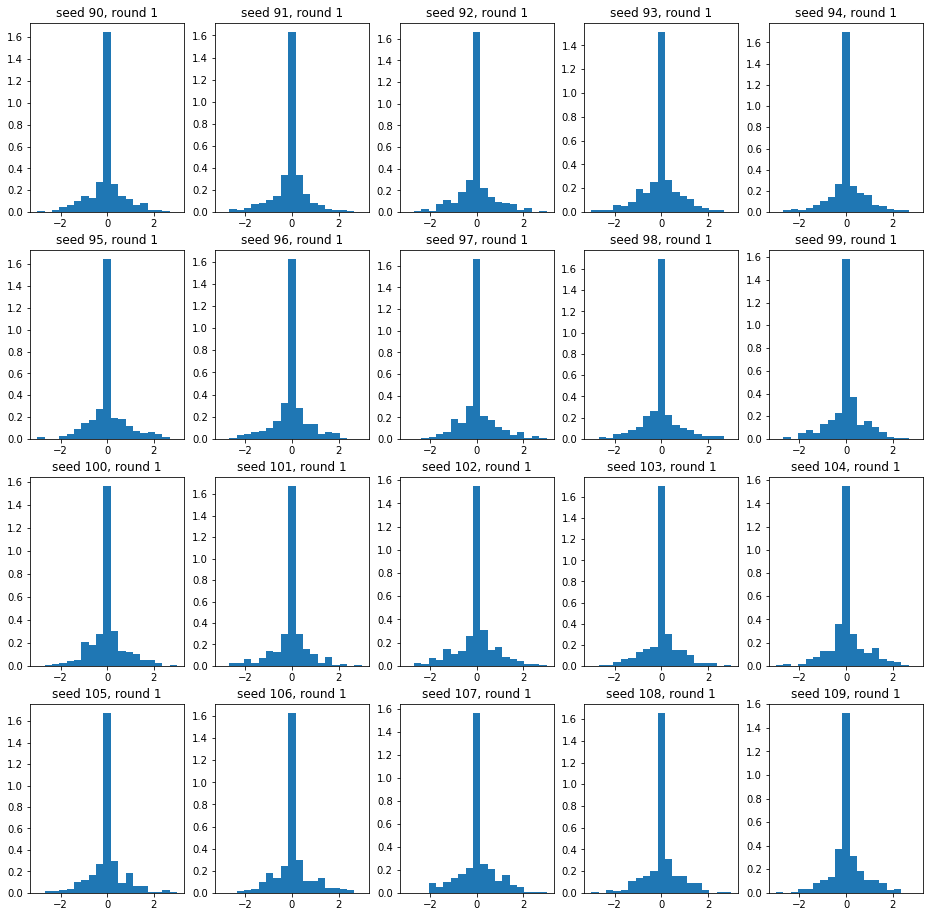

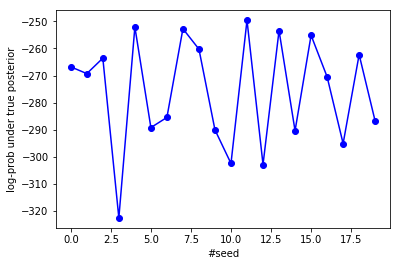

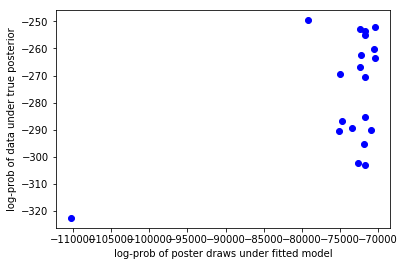

[[ 1.          0.50398228]
 [ 0.50398228  1.        ]]


In [5]:
obs = np.array([[0]])

def un_zscore(trn_data_r, seed):
    
    m = GaussMixture(dim=1, noise_cov=[1.0, 0.01], seed=seed)
    p = dd.Uniform(lower=[-10], upper=[10], seed=seed)
    s = ds.Identity()
    g = dg.Default(model=m, prior=p, summary=s)
    
    _,_ = g.gen(1, skip_feedback=True, verbose=False) # DELFI uses this to figure the shape of th, x

    _, stats = g.gen(100, verbose=False)
    stats_mean = np.nanmean(stats, axis=0)
    stats_std = np.nanstd(stats, axis=0)    
    
    return (trn_data_r[1] * stats_std) + stats_mean        
        
def reg_adj(th, x, xo, mu, sig):
                
    return mu(xo) + sig(xo) * (th - mu(x))/sig(x)

thp = p_true.gen(100000)
p_uni = dd.Gaussian(m=-0.11701747*np.ones(1), S=0.65295111*np.eye(1))
plt.figure(figsize=(16,16))

ll_unim = np.zeros(len(seeds))
ll_true = np.zeros(len(seeds))
ll_test = np.zeros(len(seeds))
conv_mat = np.zeros((len(seeds), len(seeds)))

for i in range(len(seeds)):    
    r = 0
    trn_data = all_outs_SNPE[i]['train_data'][r]

    x = un_zscore(trn_data, seeds[i])

    def mu(x):
        return x
    def sig(x):
        return 1.

    th_ = reg_adj(trn_data[0], x, obs, mu, sig)

    plt.subplot(4,5,i+1)
    plt.hist(th_, bins=np.linspace(-3, 3, 20), normed=True)
    plt.title('seed ' + str(seeds[i]) + ', round ' + str(r+1))
    
    ll_unim[i] = np.sum(p_uni.eval(th_))
    ll_true[i] = np.sum(p_true.eval(th_))
    ll_test[i] = np.sum(all_outs_SNPE[i]['posteriors'][r].eval(thp))
    
plt.show()

#plt.plot(ll_unim, 'ro-')

plt.plot(ll_true, 'bo-')
plt.ylabel('log-prob under true posterior')
plt.xlabel('#seed')
plt.show()


plt.plot(ll_test, ll_true, 'bo')
plt.ylabel('log-prob of data under true posterior')
plt.xlabel('log-prob of poster draws under fitted model')
plt.show()

print( np.corrcoef(ll_test, ll_true) )

n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


22.4124003877
n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


282.531539415
n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.04576039]: : 6it [00:00, 36.75it/s]

loss=[ 2.92778921]: : 1398it [00:20, 69.88it/s]


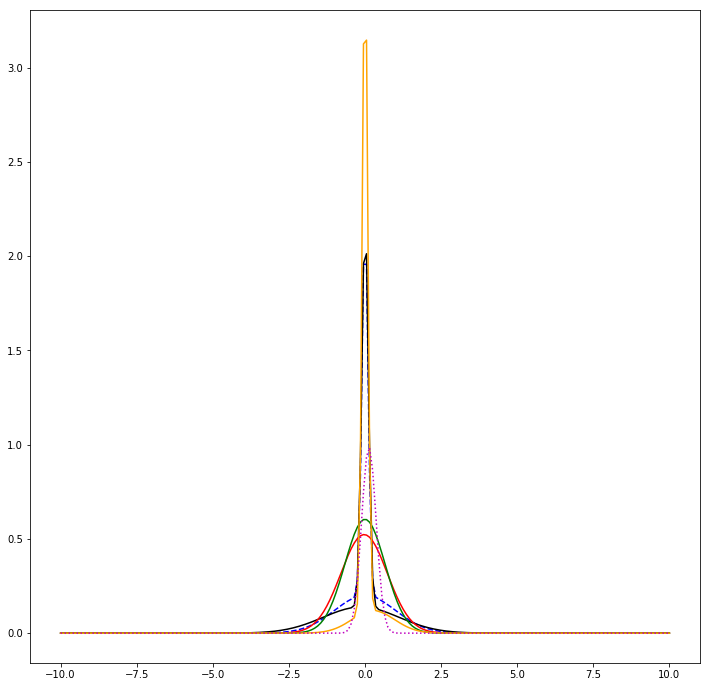

In [8]:
seed = 42

out = run_panel_a(algo='CDELFI', rounds=2, seed=seed)

out_SNPE = run_panel_a(algo='SNPE', rounds=2, seed=seed)
w = out_SNPE['train_data'][-1][2]
w /= w.sum()
print(1/np.sum(w**2))

out_kSNPE = run_panel_a(algo='kSNPE', rounds=2, seed=seed)
w = out_kSNPE['train_data'][-1][2]
w /= w.sum()
print(1/np.sum(w**2))


out_DDELFI = run_panel_a(algo='DDELFI', rounds=2, seed=seed)

%matplotlib inline
import matplotlib.pyplot as plt

p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([0.]), np.asarray([0.])], Ss=[1.0*np.eye(1), 0.01*np.eye(1)])

plt.figure(figsize=(12,12))
xx = np.linspace(-10, 10, 200).reshape(-1,1)
plt.plot(xx,                p_true.eval(xx, log=False), 'b--')
plt.plot(xx,      out['posterior'].eval(xx, log=False), 'k')
plt.plot(xx, out_SNPE['posterior'].eval(xx, log=False), 'r')
plt.plot(xx,out_kSNPE['posterior'].eval(xx, log=False), 'g')
plt.plot(xx,out_DDELFI['posterior'].eval(xx, log=False), 'orange')

plt.plot(xx, out_kSNPE['log'][-1]['cbkrnl'].eval(xx), ':', color='m')

plt.show()

n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


20.4348979108
n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


513.859764226
n_train : [200, 1000]
epochs : [50000, 10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 3.02266955]: : 0it [00:00, ?it/s]

loss=[ 3.01609445]: : 1083it [00:20, 52.03it/s]


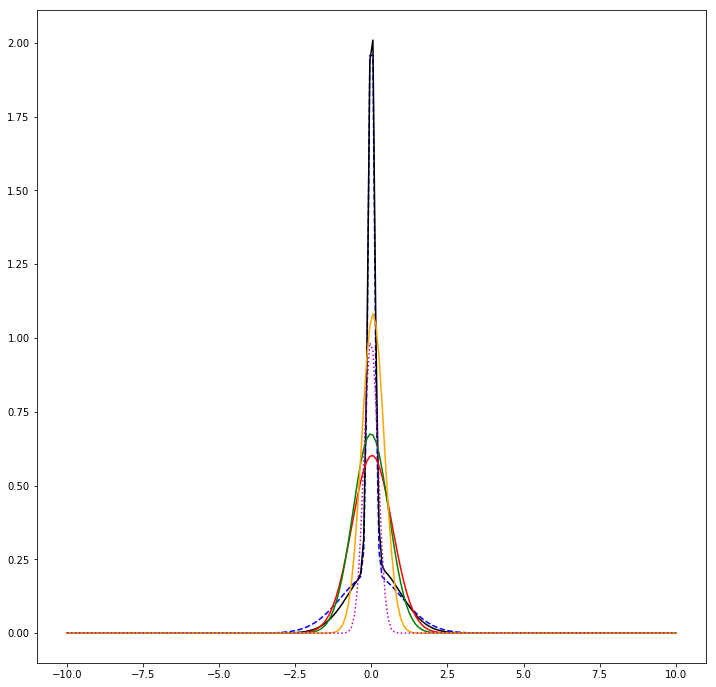

In [9]:
seed = 44

out = run_panel_a(algo='CDELFI', rounds=2, seed=seed)

out_SNPE = run_panel_a(algo='SNPE', rounds=2, seed=seed)
w = out_SNPE['train_data'][-1][2]
w /= w.sum()
print(1/np.sum(w**2))

out_kSNPE = run_panel_a(algo='kSNPE', rounds=2, seed=seed)
w = out_kSNPE['train_data'][-1][2]
w /= w.sum()
print(1/np.sum(w**2))


out_DDELFI = run_panel_a(algo='DDELFI', rounds=2, seed=seed)

%matplotlib inline
import matplotlib.pyplot as plt

p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([0.]), np.asarray([0.])], Ss=[1.0*np.eye(1), 0.01*np.eye(1)])

plt.figure(figsize=(12,12))
xx = np.linspace(-10, 10, 200).reshape(-1,1)
plt.plot(xx,                p_true.eval(xx, log=False), 'b--')
plt.plot(xx,      out['posterior'].eval(xx, log=False), 'k')
plt.plot(xx, out_SNPE['posterior'].eval(xx, log=False), 'r')
plt.plot(xx,out_kSNPE['posterior'].eval(xx, log=False), 'g')
plt.plot(xx,out_DDELFI['posterior'].eval(xx, log=False), 'orange')

plt.plot(xx, out_kSNPE['log'][-1]['cbkrnl'].eval(xx), ':', color='m')

plt.show()